# **Combined Cycle Power Plant Veri Seti**

Bu veri seti, bir kombine çevrim güç santralinin tam yükte çalıştığı 6 yıllık (2006-2011) verilere dayanmaktadır ve toplam 9568 satırdan oluşmaktadır. Excel formatında sunulan veri setinde **SAYFA2 (Sheet2)** kullanılacaktır. Verilerde ortam sıcaklığı (AT), egzoz vakumu (V), ortam basıncı (AP) ve bağıl nem (RH) gibi özellikler yer almakta olup, santralin **net saatlik elektrik enerjisi çıktısı (PE)** tahmin edilmeye çalışılacaktır. Bu, bir regresyon problemi olarak ele alınabilir.

# **Gerekli Kütüphanelerin Yüklenmesi:**
 - **_Pandas:_** Veri işleme ve analiz için
 - **_NumPy_**: Sayısal hesaplamalar ve dizi işlemleri için
 - **_Matplotlib:_** Veri görselleştirme ve grafik çizimi için
 - **_Seaborn:_** Daha gelişmiş ve estetik görselleştirmeler için
 - **_Scikit-learn:_** Makine öğrenmesi algoritmaları ve veri ön işleme araçları için
   - * **train_test_split:** Veri setini eğitim ve test olarak ayırmak için
   - * **GridSearchCV:** Modelin hiperparametre optimizasyonu için
   - * **StandardScaler:** Verilerin ölçeklendirilmesi için
   - * **KNeighborsRegressor:** K-en yakın komşu algoritması tabanlı regresyon modeli oluşturmak için
   - * **mean_squared_error ve r2_score:** Model performansını değerlendirmek için

 - **_KNeighborsRegressor nesnesinin tanımlanması :_** KNeighborsRegressor, K-en yakın komşu algoritması tabanlı regresyon modeli oluşturur.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

# KNeighborsRegressor nesnesinin tanımlanması
knn = KNeighborsRegressor()


## **Excel verisinin çalışma ortamına aktarılması**

In [2]:
# Veri Setinin Okunması
file_path = 'Folds5x2_pp.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet2')
display(data)

,AT,V,AP,RH,PE
0,9.59,38.56,1017.01,60.10,481.30
1,12.04,42.34,1019.72,94.67,465.36
2,13.87,45.08,1024.42,81.69,465.48
3,13.72,54.30,1017.89,79.08,467.05
4,15.14,49.64,1023.78,75.00,463.58
...,...,...,...,...,...
9563,17.10,49.69,1005.53,81.82,457.32
9564,24.73,65.34,1015.42,52.80,446.92
9565,30.44,56.24,1005.19,56.24,429.34
9566,23.00,66.05,1020.61,80.29,421.57


# **Veri setini görüntüleme**
- Veri setinin ilk birkaç satırı ve genel özellikleri incelenir.

In [3]:
# Veri Keşfi ve Görünüm
print("Veri Seti Bilgisi:")
print(data.info())

Veri Seti Bilgisi:
<class 'pandas.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
None


### **Korelasyon Matrisi**
Veri setindeki değişkenler arasındaki doğrusal ilişkiyi görselleştirmek için bir ısı haritası oluşturulur.

Korelasyon katsayıları, değişkenlerin birbiriyle olan ilişkisinin gücünü ve yönünü gösterir:

- **Pozitif korelasyon:** Bir değişken artarken diğeri de artar.
- **Negatif korelasyon:** Bir değişken artarken diğeri azalır.
- **0'a yakın değerler:** Değişkenler arasında anlamlı bir ilişki yoktur.


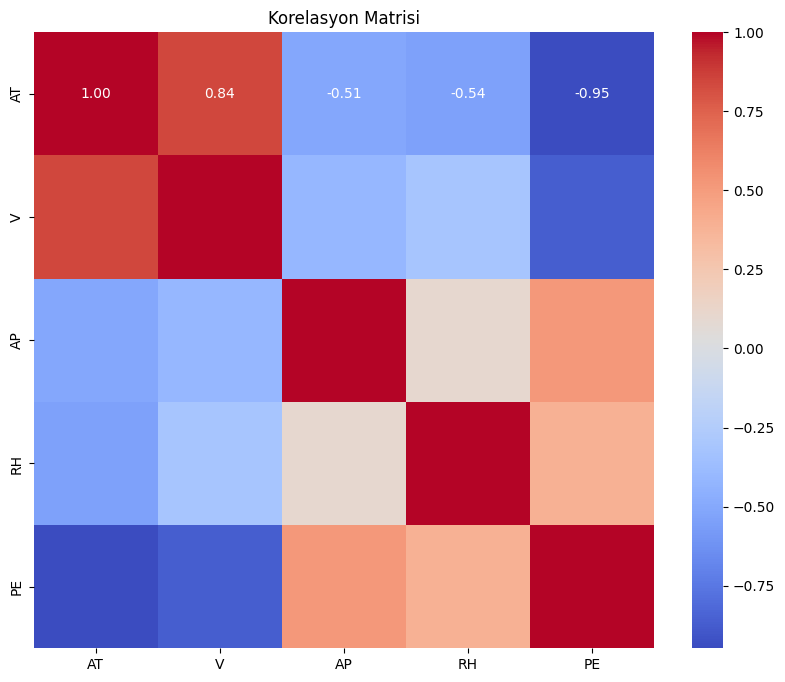

In [4]:
# Korelasyon Matrisi
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Korelasyon Matrisi')
plt.show()

###  Özellikler ve Hedef Değerlerin Ayrılması
Bu adımda veri seti, modelin eğitimi ve tahmini için iki bölüme ayrılır:

- **X (Özellikler):** Tahmin yapılırken kullanılacak bağımsız değişkenler. `data.iloc[:, :-1].values` ile veri setinin son sütunu hariç tüm sütunları seçilir.
  - `data.iloc[:, :-1]`: Pandas `iloc` özelliği ile satır ve sütun dilimleri alınır. `:-1` ifadesi, son sütun hariç tüm sütunları ifade eder.
  - `.values`: Seçilen sütunları NumPy dizisi (array) formatına çevirir.

- **y (Hedef Değer):** Tahmin edilecek bağımlı değişken (etiket). `data.iloc[:, -1].values` ile veri setinin sadece son sütunu seçilir.
  - `data.iloc[:, -1]`: Sadece son sütunu seçer.
  - `.values`: Seçilen sütunu NumPy dizisi formatına çevirir.

Bu ayrım, makine öğrenmesi modellerinde standart bir prosedürdür. Bağımsız değişkenler (X) modelin tahminler yapması için kullanılırken, bağımlı değişken (y) modelin öğrenmesi ve test edilmesi için referans olarak kullanılır.


In [5]:
# 3. Özellikler ve Hedef Değerlerin Ayrılması
X = data.iloc[:, :-1].values  # Özellikler (son sütun hariç tüm sütunlar)
y = data.iloc[:, -1].values  # Hedef değer (son sütun: PE)


###  Eğitim ve Test Setlerine Ayrılması
- **Eğitim seti (X_train, y_train):** Model, bu verilerle eğitilir.
- **Test seti (X_test, y_test):** Modelin eğitilmeyen yeni verilere karşı performansı değerlendirilir.

In [6]:
# Eğitim ve Test Setlerine Ayrılması
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


###  Verilerin Ölçeklendirilmesi
Bu adımda, **StandardScaler** kullanılarak özellikler standart normal dağılıma (ortalama = 0, standart sapma = 1) dönüştürülür. 

- **`fit_transform(X_train)`**: Eğitim verisini ölçeklendirir ve dönüştürür.
- **`transform(X_test)`**: Eğitim setinden öğrenilen ölçeği test setine uygular.

**Amaç:** Özellikler arasındaki ölçek farklılıklarını kaldırarak, algoritmanın daha doğru çalışmasını sağlamak.


In [7]:
# Verilerin Ölçeklendirilmesi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

###  KNN Modeli ve Hiperparametre Optimizasyonu
Bu adımda, KNN modelinin hiperparametreleri **GridSearchCV** ile optimize edilir.

- **Hiperparametreler:**
  - `n_neighbors`: Komşu sayısını belirtir. Daha az komşu modelin eğitim verisine fazla uyum sağlamasına, daha fazla komşu ise genelleme yapmasına neden olabilir. **_Bu, MSE ve R² değerlerini doğrudan etkiler._**
   
  -  EĞİTİM SETİ PERFORMANSI İÇİN **_MSE ve R²_** FARKLI DEĞERLER BULDUM **_n_neighbors_** DEĞERLERİNİ DEĞİŞTİREREK İYİ PERFORMANS GÖSTERDİĞİ NOKTALARI SEÇTİM
  - `weights`: Komşuların ağırlıklandırma yöntemi (ör. uniform).
  - `metric`: Mesafe ölçüm metrikleri (ör. euclidean, manhattan).

- **GridSearchCV:** Belirtilen hiperparametre kombinasyonlarını dener ve en iyi sonucu veren parametreleri seçer. 
  - `cv=5`: 5 katlı çapraz doğrulama yapılır.
  - `scoring='neg_mean_squared_error'`: Ortalama kare hatası (MSE) minimizasyonuna göre değerlendirilir.

- **Çıktı:**
  - `best_knn`: En iyi parametrelerle oluşturulan model.
  - `grid_search.best_params_`: En iyi hiperparametrelerin sözlüğü.

**Amaç:** Modelin genelleştirme yeteneğini artırmak ve eğitim/test performansını (MSE ve R²) iyileştirmek.

In [8]:
#  KNN Modeli ve Hiperparametre Optimizasyonu
param_grid = {
    'n_neighbors': [ 3, 7, 13, 18, 23],
    'weights': ['uniform'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV ile model optimizasyonu
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# En iyi parametrelerle modeli oluştur
best_knn = grid_search.best_estimator_
print("\nEn İyi Parametreler:", grid_search.best_params_)


En İyi Parametreler: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}


### Model Performansının Değerlendirilmesi
Bu adımda, eğitim ve test seti üzerinde modelin performansı hesaplanır:

- **Tahminler:**
  - **`y_train_pred`**: Eğitim seti için tahmin edilen değerler.
  - **`y_test_pred`**: Test seti için tahmin edilen değerler.

- **Performans Metrikleri:**
  - **MSE (Ortalama Kare Hatası):** Tahminlerin doğruluğunu ölçer. Daha düşük değerler daha iyi performansı gösterir.
  - **R² Skoru:** Modelin açıklama gücünü ölçer. 1'e yakın değerler daha iyi bir uyumu ifade eder.

In [9]:
y_train_pred = best_knn.predict(X_train_scaled)
y_test_pred = best_knn.predict(X_test_scaled)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nEğitim Seti Performansı:")
print(f"- Ortalama Kare Hatası (MSE): {train_mse:.4f}")
print(f"- R² Skoru: {train_r2:.4f}")

print("\nTest Seti Performansı:")
print(f"- Ortalama Kare Hatası (MSE): {test_mse:.4f}")
print(f"- R² Skoru: {test_r2:.4f}")


Eğitim Seti Performansı:
- Ortalama Kare Hatası (MSE): 6.4866
- R² Skoru: 0.9775

Test Seti Performansı:
- Ortalama Kare Hatası (MSE): 14.0194
- R² Skoru: 0.9538


### Gerçek vs Tahmin Değerleri Grafiği
Bu grafik, test setindeki gerçek değerler (`y_test`) ile modelin tahmin ettiği değerleri (`y_test_pred`) karşılaştırır.

- **Amaç:**
  - Modelin test setinde ne kadar doğru tahmin yaptığını görselleştirmek.
  - Gerçek ve tahmin edilen değerlerin uyumunu değerlendirmek.

- **Grafik Detayları:**
  - **Mavi noktalar:** Her bir veri noktasında gerçek ve tahmin edilen değerlerin dağılımı.
  - **Kırmızı çizgi:** İdeal tahmin çizgisi (gerçek = tahmin). Noktalar bu çizgiye ne kadar yakınsa tahminler o kadar doğrudur.
  - **Eksenler:**
    - X ekseni: Gerçek değerler (PE).
    - Y ekseni: Tahmin edilen değerler (PE).

**Sonuç:** Tahminlerin doğruluğu ve modelin genelleme kabiliyeti bu grafikle kolayca değerlendirilebilir.

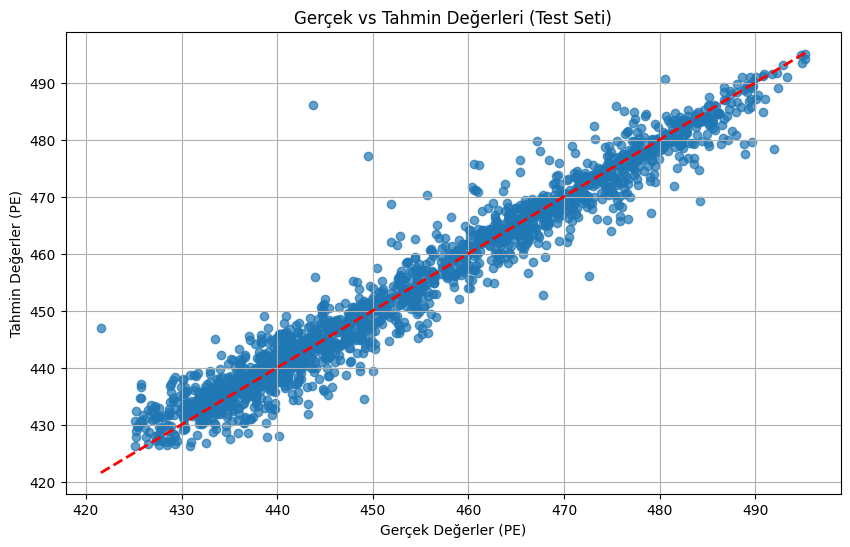

In [10]:
# 8. Grafiksel Gösterimler
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)
plt.title('Gerçek vs Tahmin Değerleri (Test Seti)')
plt.xlabel('Gerçek Değerler (PE)')
plt.ylabel('Tahmin Değerler (PE)')
plt.grid(True)
plt.show()

### Hata Dağılımı (Test Seti)
Bu grafik, test setindeki tahmin hatalarının (`Gerçek - Tahmin`) dağılımını gösterir.

- **Amaç:**
  - Modelin test setindeki tahminlerde ne kadar hata yaptığını analiz etmek.
  - Hataların dağılımının simetrik olup olmadığını incelemek.

- **Grafik Detayları:**
  - **X ekseni:** Hata değerleri (gerçek - tahmin).
  - **Y ekseni:** Hataların frekansı (kaç kez gerçekleştiği).
  - **Turuncu çubuklar:** Hataların histogramı, tahminlerdeki yayılımı görselleştirir.

**Sonuç:** 
- Hataların merkezde yoğunlaşması modelin genelde doğru tahmin yaptığını gösterir.
- Hataların çok geniş bir alana yayılması, modelin belirli durumlarda düşük performans gösterebileceğini işaret eder.


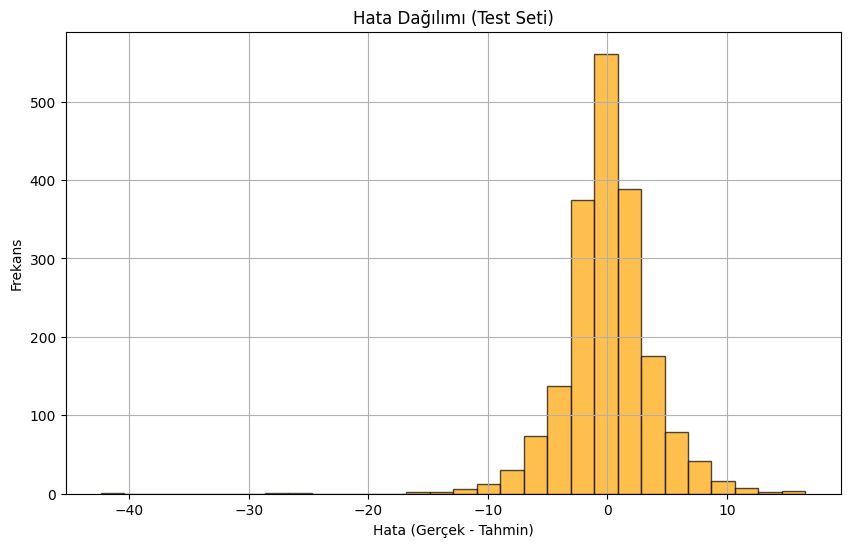

In [11]:
# Hata Dağılımı (Test Seti)
errors = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.title('Hata Dağılımı (Test Seti)')
plt.xlabel('Hata (Gerçek - Tahmin)')
plt.ylabel('Frekans')
plt.grid(True)
plt.show()

### Gerçek ve Tahmin Edilen Değerlerin Zaman Serisi Grafiği
Bu grafik, test setindeki ilk 100 veri noktası için gerçek (`y_test`) ve tahmin edilen (`y_test_pred`) değerlerin zaman içindeki değişimini gösterir.

- **Amaç:** Tahminlerin doğruluğunu ve modelin zaman serisi boyunca tutarlılığını değerlendirmek.
- **Detaylar:**
  - `Mavi çizgi:` Gerçek değerler.
  - `Turuncu çizgi:` Tahmin edilen değerler.

**Sonuç:** Çizgilerin uyumu, modelin doğruluğunu; sapmalar ise hata oranını gösterir.


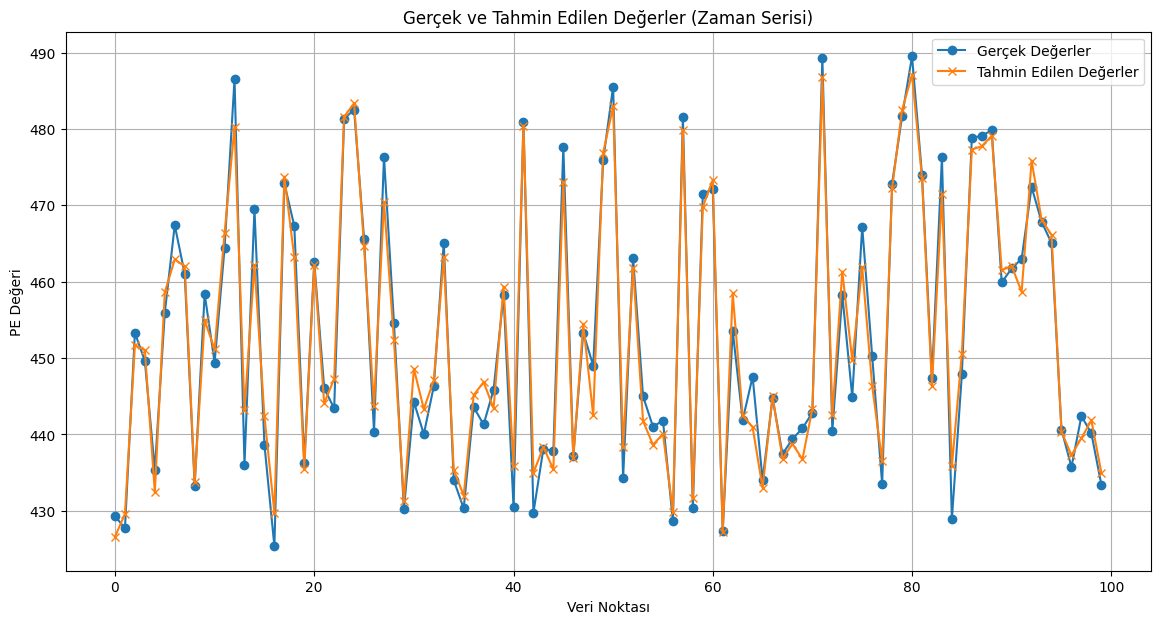

In [12]:
# Gerçek ve Tahmin Edilen Değerlerin Zaman Serisi Grafiği
plt.figure(figsize=(14, 7))
plt.plot(y_test[:100], label='Gerçek Değerler', marker='o')
plt.plot(y_test_pred[:100], label='Tahmin Edilen Değerler', marker='x')
plt.title('Gerçek ve Tahmin Edilen Değerler (Zaman Serisi)')
plt.xlabel('Veri Noktası')
plt.ylabel('PE Değeri')
plt.legend()
plt.grid(True)
plt.show()